# STATISTICAL ARBITRAGE MODEL (PAIR TRADING)
An academic exposition into the Statistical Arbitrage Trading Strategy. I will cover learnings about the strategy and work with data. We explore pair trading taking related pairs.
When to use the strategy :
1. in the absense of Law of One Price
2. cointegration of two time series is possible
Assuming we do not account for the cost of transactions etc. because of which we use adjusted closing prices.
This is what we will explore in the beginning.


Pair of instruments considered = ETF's = EWA (Australia) and EWC (Canada)

**Data Preprocessing and Visualization**
1. Lineplot and boxplot: discovering patterns and outliers from data (reduction of noise)
2. Cointegrated Augmented Dicky Fuller Test: To prove cointegration between the two time series'



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ishares-australia-and-canada/EWA.csv
/kaggle/input/ishares-australia-and-canada/EWC.csv


In [2]:
Aus_data = pd.read_csv("/kaggle/input/ishares-australia-and-canada/EWA.csv")
Can_data = pd.read_csv("/kaggle/input/ishares-australia-and-canada/EWC.csv")
Aus_data.info() # no missing values except for week ends
Aus_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Open       252 non-null    float64
 2   High       252 non-null    float64
 3   Low        252 non-null    float64
 4   Close      252 non-null    float64
 5   Adj Close  252 non-null    float64
 6   Volume     252 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-16,25.360001,25.410000,25.260000,25.330000,24.107340,4729900
1,2021-02-17,25.120001,25.250000,25.020000,25.190001,23.974094,2035500
2,2021-02-18,25.280001,25.340000,25.120001,25.270000,24.050236,2579800
3,2021-02-19,25.280001,25.360001,25.230000,25.290001,24.069269,2553400
4,2021-02-22,25.299999,25.530001,25.270000,25.379999,24.154924,3471300


In [3]:
Can_data.info() # no missing values except for weekends
Can_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Open       252 non-null    float64
 2   High       252 non-null    float64
 3   Low        252 non-null    float64
 4   Close      252 non-null    float64
 5   Adj Close  252 non-null    float64
 6   Volume     252 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-16,33.009998,33.200001,32.919998,33.029999,32.414864,1920800
1,2021-02-17,32.759998,32.820000,32.470001,32.790001,32.179337,2733700
2,2021-02-18,32.630001,32.759998,32.439999,32.700001,32.091011,2228900
3,2021-02-19,32.840000,33.070000,32.799999,33.040001,32.424679,1873100
4,2021-02-22,32.939999,33.250000,32.849998,33.119999,32.503185,2091100


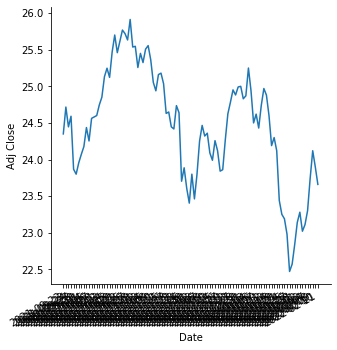

In [4]:
# Taking subset of data and visualizing it as a line plot
# doing the same for adjusted closing prices of both ETF's

import seaborn as sns
New_Aus_data = Aus_data.loc[152:252]
g = sns.relplot(x="Date", y="Adj Close", kind="line", data=New_Aus_data)
g.figure.autofmt_xdate()

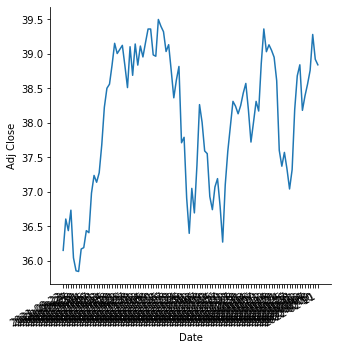

In [5]:
New_Can_data = Can_data.loc[152:252]
g = sns.relplot(x="Date", y="Adj Close", kind="line", data=New_Can_data)
g.figure.autofmt_xdate()

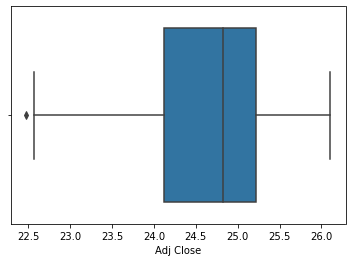

In [6]:
# EWA data shows few outliers and a left skewed graph

ax = sns.boxplot(x=Aus_data["Adj Close"])

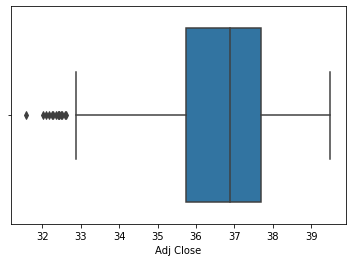

In [7]:
# EWC data shows greater number of outliers and a left skewed graph as well

ax = sns.boxplot(x=Can_data["Adj Close"])

The lineplots and boxplots seem to correlate with each other. Depending on the points in time for bullish and bearish signals, if we can prove a cointegration in these two time series' then we can establish a strategy to profit (using mean reversal techniques) from systematic buying and selling of ETF's. We therefore conduct the following test:

# COINTEGRATED AUGMENTED DICKEY FULLER TEST
$H_0:$ a unit root is not present in our pair of ETF's chosen

$H_a:$ a unit root is present in our pair of ETF's chosen

(From Wikipedia : "In probability theory and statistics, a unit root is a feature of some stochastic processes (such as random walks) that can cause problems in statistical inference involving time series models."

In [8]:
# Code taken from https://gist.github.com/jcorrius/e79c6372a24c0f402f4bcb29b0fca05b
# Conducts (Cointegrated) Augmented Dickey Fuller unit root test
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.tsatools import lagmat, add_trend
from statsmodels.tsa.adfvalues import mackinnonp

 
def adf(ts, maxlag=1):
    """
    Augmented Dickey-Fuller unit root test
    """
    # Get the dimension of the array
    nobs = ts.shape[0]
         
    # Calculate the discrete difference
    tsdiff = np.diff(ts)
     
    # Create a 2d array of lags, trim invalid observations on both sides
    tsdall = lagmat(tsdiff[:, None], maxlag, trim='both', original='in')
    # Get dimension of the array
    nobs = tsdall.shape[0] 
     
    # replace 0 xdiff with level of x
    tsdall[:, 0] = ts[-nobs - 1:-1]  
    tsdshort = tsdiff[-nobs:]
     
    # Calculate the linear regression using an ordinary least squares model    
    results = OLS(tsdshort, add_trend(tsdall[:, :maxlag + 1], 'c')).fit()
    adfstat = results.tvalues[0]
     
    # Get approx p-value from a precomputed table (from stattools)
    pvalue = mackinnonp(adfstat, 'c', N=1)
    return pvalue
 
def cadf(x, y):
    """
    Returns the result of the Cointegrated Augmented Dickey-Fuller Test
    """
    # Calculate the linear regression between the two time series
    ols_result = OLS(x, y).fit()
     
    # Augmented Dickey-Fuller unit root test
    return adf(ols_result.resid)


In [9]:
# returning p value of cointegration test at 5% alpha
cadf(Aus_data["Adj Close"],Can_data["Adj Close"])

0.8136460180504417

Since the P value > $\alpha(5\%)$, we fail to reject the null hypothesis and we can hence claim that the data does not provide sufficient evidence to reject our null hypothesis that a unit root is not present in our pair and hence the two time series are cointegrated. 

We can use this information for arbitrage purposes and hence generate alpha in the markets. The given example was taken from Ernie Chan's book and back in the days of arbitrage trading, could have been used to gain profits. 

This strategy has lost its sheen in recent times due to the occurrence of High Frequency Trading (HFT) due to which arbitraging opportunities have been reduced to nil.

This project has taken a lot of help from the internet and is not in any sense, any kind of financial advice(as I have mentioned before it is not profitable in the competitive markets of today unless lightning fast computers even faster than computers that exist today are applied) 